In [1]:
exp = "exp050_llama"
device_id = 0

In [2]:
# %cd ..
import sys

In [ ]:
sys.path.append('..')
from train import load_model, apply_lora_model

In [35]:
import glob
import os
import sys
from base64 import b64decode
from io import BytesIO
from PIL import Image

from transformers import (
    AutoTokenizer,
    CLIPImageProcessor,
    AutoProcessor,
    TrainingArguments,
    Trainer,
    AutoModelForCausalLM
)
import re
import datasets
import torch
from torch.utils.data import Dataset
import yaml
import deepspeed
import fire
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import japanize_matplotlib
from peft import LoraConfig, get_peft_config, get_peft_model
import requests

from git_llm.git_opt import GitOPTForCausalLM, GitOPTConfig
from git_llm.git_llama import GitLlamaForCausalLM, GitLlamaConfig
from tqdm import tqdm
import requests

# Functions

In [5]:
def generate_text(model, data, processor):
    eos_token_id_list = [
        processor.tokenizer.pad_token_id,
        processor.tokenizer.eos_token_id,
    ]
    with torch.no_grad():
        out = model.generate(**data, max_length=256, do_sample=False, temperature=0., eos_token_id=eos_token_id_list)
        return processor.tokenizer.batch_decode(out)

# SupervisedDataset
class SupervisedDataset(Dataset):
    """Dataset for supervised learning"""

    def __init__(
        self,
        model_name: str,
        vision_model_name: str,
        loaded_dataset: datasets.GeneratorBasedBuilder,
        max_length: int = 128,
    ):
        super(SupervisedDataset, self).__init__()
        self.loaded_dataset = loaded_dataset
        self.max_length = max_length

        self.processor = AutoProcessor.from_pretrained("microsoft/git-base")
        self.processor.image_processor = CLIPImageProcessor.from_pretrained(vision_model_name)
        self.processor.tokenizer = AutoTokenizer.from_pretrained(
            model_name, padding_side="right", use_fast=False
        )
        if "llama" in model_name:
            self.processor.tokenizer.pad_token = self.processor.tokenizer.eos_token

    def __len__(self) -> int:
        return len(self.loaded_dataset)

    def __getitem__(self, index) -> dict:
        # cf: https://huggingface.co/datasets/MMInstruction/M3IT#data-instances
        row = self.loaded_dataset[index]

        instruction = row["instruction"]  # str
        question = row["inputs"]  # str
        answer = row["outputs"]  # str
        full_text = f"##Instruction: {instruction} ##Question: {question} ##Answer: {answer}"
        text = f"##Instruction: {instruction} ##Question: {question} ##Answer:"

        # imageのロード
        image_base64_str_list = row["image_base64_str"]  # str (base64)
        img = Image.open(BytesIO(b64decode(image_base64_str_list[0])))

        inputs = self.process_data(text, img)

        return inputs, img, text, full_text

    def process_data(self, text, img):
        inputs = self.processor(
            text,
            img,
            return_tensors="pt",
            # max_length=self.max_length,
            # padding="max_length",
            truncation=True,
        )
        inputs = {k: v.to(f"cuda:{device_id}") for k, v in inputs.items()}
        inputs["pixel_values"] = inputs["pixel_values"].to(torch.float16)
        inputs["labels"] = None
        return inputs

In [20]:
def download_image(url, folder='photos'):
    if not os.path.exists(folder):
        os.makedirs(folder)

   # Extracting image name from url
    image_name = url.split('/')[-1].split('?')[0] + '.jpg'
    image_path = os.path.join(folder, image_name)

    if os.path.exists(image_path): return image_path
    
    response = requests.get(url)
    if response.status_code == 200:
        with open(image_path, 'wb') as f:
            f.write(response.content)
        return image_path
    else:
        return 'Failed to download'
    

# Define the function to download images and extract the fullUrl from the media string
def download_and_extract_fullurl(index, row, folder='photos'):
    photo = row['media']
   
    path = ""
    try:
        # Regular expression to find the thumbnailUrl
        thumbnail_url_match = re.search("thumbnailUrl='(.*?)'", photo)
        
        # Extract the thumbnail URL if it's found
        thumbnail_url = thumbnail_url_match.group(1) if thumbnail_url_match else None
        
        # Regular expression to find the fullUrl
        full_url_match = re.search("fullUrl='(.*?)'", photo)
        
        # Extract the full URL if it's found
        full_url = full_url_match.group(1) if full_url_match else None

        if full_url:
            path = download_image(full_url, folder)
        else:
            path = download_image(thumbnail_url, folder)
    except Exception as e:
        print(f"Error downloading image at index {index}: {e}")
        pass
    
    return path

# Load configs

In [6]:
config_file = f"../configs/training_config_{exp}.yml"

# get config
with open(config_file, "r") as i_:
    config = yaml.safe_load(i_)


# model
model_name = config["settings"]["model_name"]
vision_model_name = config["settings"]["vision_model_name"]
num_image_with_embedding = config["settings"]["num_image_with_embedding"]

keys_finetune = config["settings"]["keys_finetune"]

# Load thepretrained model

In [7]:
model = load_model(model_name, vision_model_name, num_image_with_embedding)

# lora
if config["use_lora"]:
    keys_finetune.append("lora")
    model = apply_lora_model(model, model_name, config)

weight = {}
weight_path = glob.glob(f'../output/{exp}/checkpoint*/pytorch*.bin')
for w in weight_path:
    weight_temp = torch.load(w, map_location="cpu")
    weight.update(weight_temp)
model.load_state_dict(weight, strict=False)

model.eval()
model.to(f"cuda:{device_id}")
print("Complete preparing an eval model")

You are using a model of type llama to instantiate a model of type git_llama. This is not supported for all configurations of models and can yield errors.
Loading checkpoint shards: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.63it/s]
Some weights of GitLlamaForCausalLM were not initialized from the model checkpoint at meta-llama/Llama-2-7b-chat-hf and are newly initialized: ['model.image_encoder.vision_model.encoder.layers.10.layer_norm1.bias', 'model.image_encoder.vision_model.pre_layrnorm.weight', 'model.image_encoder.vision_model.encoder.layers.9.layer_norm1.bias', 'model.image_encoder.vision_model.encoder.layers.0.self_attn.out_proj.bias', 'model.image_encoder.vision_model.encoder.layers.3.self_attn.v_proj.bias', 'model.image_encoder.vision_model.encoder.layers.6.mlp.fc1.weight', 'model.image_encoder.vision_model.encoder.layers.10.self_attn.k_proj.bias', 'model.visual_projection.vi

Complete preparing an eval model


In [23]:
processor = AutoProcessor.from_pretrained("microsoft/git-base")
processor.image_processor = CLIPImageProcessor.from_pretrained(vision_model_name)
processor.tokenizer = AutoTokenizer.from_pretrained(
    model_name, padding_side="right", use_fast=False
)
if "llama" in model_name:
    processor.tokenizer.pad_token = processor.tokenizer.eos_token

# Final Inference

In [9]:
# %cd ..

In [10]:
df = pd.read_excel('behaviour_simulation_test_company.xlsx')

In [11]:
sample = df.iloc[0]

In [12]:
sample

id                                                                  1
date                                              2019-01-08 18:03:10
content                      the Heathrow drone right now <hyperlink>
username                                                     bbcthree
media               [Photo(previewUrl='https://pbs.twimg.com/media...
inferred company                                                  bbc
Name: 0, dtype: object

In [24]:
image_path = download_and_extract_fullurl(0, sample, 'test_photos')
print(image_path)
image = Image.open(image_path)
inputs = processor(
    text,
    image,
    return_tensors="pt",
    # max_length=self.max_length,
    # padding="max_length",
    truncation=True,
)
inputs = {k: v.to(f"cuda:{device_id}") for k, v in inputs.items()}
inputs["pixel_values"] = inputs["pixel_values"].to(torch.float16)
inputs["labels"] = None

text = generate_text(model, inputs, processor)[0]
likes = int(text.split("##Answer:")[1].split("</s>")[0].strip())

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


test_photos/DwaFKixW0AIjsun.jpg


In [28]:
content = sample['content']
username = sample['username']
company = sample['inferred company']

text = f'''Below is the context about twitter posted by {username} belonging to {company}:
{content}
You have to answer the question given to you accurately.
'''

text = f"##Instruction: {text} ##Question: How many likes must this tweet would have earned ? ##Answer:"

print(f'Prompt: ', text)

Prompt:  ##Instruction: Below is the context about twitter posted by bbcthree belonging to bbc:
the Heathrow drone right now <hyperlink>
You have to answer the question given to you accurately.
 ##Question: How many likes must this tweet would have earned ? ##Answer:


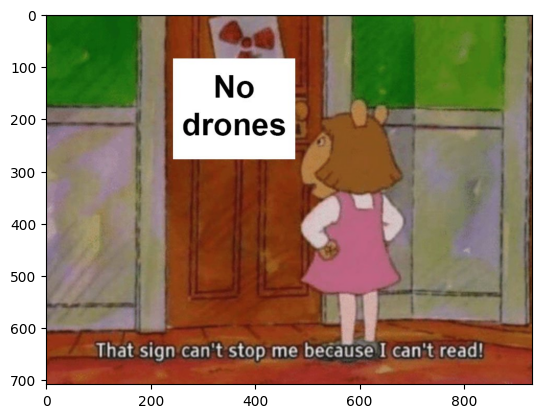

In [29]:
plt.imshow(image)

In [32]:
print('Predicted Likes :', likes)

Predicted Likes : 108


# Generate likes for all test samples

In [14]:
from tqdm import tqdm
import requests

In [15]:
total_likes = []

In [16]:
# url = "https://images.unsplash.com/photo-1602271886918-bafecc837c7a?w=600&auto=format&fit=crop&q=60&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8Mnx8c29tZXxlbnwwfHwwfHx8MA%3D%3total_likes = []
with tqdm(total=df.shape[0]) as pbar: 
    for i, sample in df.iterrows():
        content = sample['content']
        username = sample['username']
        company = sample['inferred company']
        
        text = f'''Below is the context about twitter posted by {username} belonging to {company}:
        {content}
        You have to answer the question given to you accurately.
        '''
        
        text = f"##Instruction: {text} ##Question: How many likes must this tweet would have earned ? ##Answer:"
        
        # Read the corresponding image
        
        try: 
            image_path = download_and_extract_fullurl(0, sample)
            image = Image.open(image_path)
            inputs = processor(
                text,
                image,
                return_tensors="pt",
                # max_length=self.max_length,
                # padding="max_length",
                truncation=True,
            )
            inputs = {k: v.to(f"cuda:{device_id}") for k, v in inputs.items()}
            inputs["pixel_values"] = inputs["pixel_values"].to(torch.float16)
            inputs["labels"] = None
            
            text = generate_text(model, inputs, processor)[0]
            likes = int(text.split("##Answer:")[1].split("</s>")[0].strip())
            total_likes.append(str(likes))
        except: 
            print(sample['media'])
            total_likes.append(str(0))
        pbar.update(1)

  0%|▎                                                                                                           | 29/10000 [00:11<57:35,  2.89it/s]

[Video(thumbnailUrl='https://pbs.twimg.com/ext_tw_video_thumb/1248959023979933697/pu/img/Mmqu8tEtUJtriYTE.jpg', variants=[VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1248959023979933697/pu/vid/480x270/r1Lv8J0-2QPlHo4L.mp4?tag=10', bitrate=256000), VideoVariant(contentType='application/x-mpegURL', url='https://video.twimg.com/ext_tw_video/1248959023979933697/pu/pl/__x6ypUwUIVh_xmk.m3u8?tag=10', bitrate=None), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1248959023979933697/pu/vid/1280x720/7Pwci7zTRdtbwxkD.mp4?tag=10', bitrate=2176000), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1248959023979933697/pu/vid/640x360/CFw9xQXWG89Z96QB.mp4?tag=10', bitrate=832000)], duration=27.945, views=897)]


  0%|▎                                                                                                         | 33/10000 [00:12<1:04:57,  2.56it/s]

[Gif(thumbnailUrl='https://pbs.twimg.com/tweet_video_thumb/D_oDqzxU4AAZN8S.jpg', variants=[VideoVariant(contentType='video/mp4', url='https://video.twimg.com/tweet_video/D_oDqzxU4AAZN8S.mp4', bitrate=0)])]


  1%|█                                                                                                           | 93/10000 [00:35<51:52,  3.18it/s]

[Photo(previewUrl='https://pbs.twimg.com/media/DcbNhJsVAAAFQMD?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/DcbNhJsVAAAFQMD?format=jpg&name=large')]


  4%|████▎                                                                                                    | 413/10000 [02:40<1:20:19,  1.99it/s]

[Gif(thumbnailUrl='https://pbs.twimg.com/tweet_video_thumb/EMudEYoX0AgbG_W.jpg', variants=[VideoVariant(contentType='video/mp4', url='https://video.twimg.com/tweet_video/EMudEYoX0AgbG_W.mp4', bitrate=0)])]


  5%|█████▏                                                                                                   | 492/10000 [03:33<1:45:29,  1.50it/s]/home/mac/miniconda3/envs/git_llm/lib/python3.10/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
  5%|█████▎                                                                                                   | 509/10000 [03:45<1:40:11,  1.58it/s]

[Photo(previewUrl='https://pbs.twimg.com/media/DqDZcp2VsAAPA8g?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/DqDZcp2VsAAPA8g?format=jpg&name=large')]


  6%|██████▋                                                                                                  | 638/10000 [05:13<1:35:11,  1.64it/s]

[Photo(previewUrl='https://pbs.twimg.com/media/Dq14GkgUcAAXI19?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/Dq14GkgUcAAXI19?format=jpg&name=large'), Photo(previewUrl='https://pbs.twimg.com/media/Dq14G78UUAANIna?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/Dq14G78UUAANIna?format=jpg&name=large'), Photo(previewUrl='https://pbs.twimg.com/media/Dq14HZ1UwAA5Q0k?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/Dq14HZ1UwAA5Q0k?format=jpg&name=large'), Photo(previewUrl='https://pbs.twimg.com/media/Dq14IB6U0AE4DlH?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/Dq14IB6U0AE4DlH?format=jpg&name=large')]


  7%|███████▌                                                                                                 | 717/10000 [06:07<1:10:36,  2.19it/s]

[Photo(previewUrl='https://pbs.twimg.com/media/D2dbykpU4AAOmdh?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/D2dbykpU4AAOmdh?format=jpg&name=large'), Photo(previewUrl='https://pbs.twimg.com/media/D2dbyllUcAA_sJN?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/D2dbyllUcAA_sJN?format=jpg&name=large'), Photo(previewUrl='https://pbs.twimg.com/media/D2dbylRVAAA4Boa?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/D2dbylRVAAA4Boa?format=jpg&name=large')]


  8%|███████▉                                                                                                 | 758/10000 [06:32<1:12:30,  2.12it/s]

[Photo(previewUrl='https://pbs.twimg.com/media/Di_zWKtW4AAPQ1B?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/Di_zWKtW4AAPQ1B?format=jpg&name=large')]


  9%|█████████                                                                                                | 867/10000 [07:42<1:15:54,  2.01it/s]

[Photo(previewUrl='https://pbs.twimg.com/media/DV3bfdkUMAA_6tF?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/DV3bfdkUMAA_6tF?format=jpg&name=large')]


  9%|█████████▎                                                                                               | 887/10000 [07:55<1:24:20,  1.80it/s]

[Video(thumbnailUrl='https://pbs.twimg.com/ext_tw_video_thumb/1228158973360033799/pu/img/ljlZhD2W94wsFJwS.jpg', variants=[VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1228158973360033799/pu/vid/606x1280/2vw61cQ2DkvaeKMw.mp4?tag=10', bitrate=2176000), VideoVariant(contentType='application/x-mpegURL', url='https://video.twimg.com/ext_tw_video/1228158973360033799/pu/pl/nYTqt93QAoOpabNn.m3u8?tag=10', bitrate=None), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1228158973360033799/pu/vid/320x674/492B-2h1cgOBmqXV.mp4?tag=10', bitrate=632000), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1228158973360033799/pu/vid/360x760/24XuYBu2olDL4I68.mp4?tag=10', bitrate=832000)], duration=140.028, views=32077)]


  9%|█████████▋                                                                                               | 923/10000 [08:18<1:15:45,  2.00it/s]

[Photo(previewUrl='https://pbs.twimg.com/media/D0BdH8-X4AEPjve?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/D0BdH8-X4AEPjve?format=jpg&name=large')]


 10%|██████████                                                                                               | 959/10000 [08:39<1:11:31,  2.11it/s]

[Photo(previewUrl='https://pbs.twimg.com/media/EcLZmXrWkAAn-V0?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/EcLZmXrWkAAn-V0?format=jpg&name=large')]


 13%|█████████████▏                                                                                          | 1268/10000 [11:52<1:16:26,  1.90it/s]

[Photo(previewUrl='https://pbs.twimg.com/media/DTU3vDVV4AEUoSu?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/DTU3vDVV4AEUoSu?format=jpg&name=large')]


 14%|██████████████▍                                                                                         | 1383/10000 [13:03<1:08:01,  2.11it/s]

[Photo(previewUrl='https://pbs.twimg.com/media/D7Gv0IyU0AE7pyb?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/D7Gv0IyU0AE7pyb?format=jpg&name=large')]


 15%|███████████████▊                                                                                        | 1525/10000 [14:30<1:12:40,  1.94it/s]

[Video(thumbnailUrl='https://pbs.twimg.com/ext_tw_video_thumb/975932329519714305/pu/img/ZxpuhRVZk-N88T-8.jpg', variants=[VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/975932329519714305/pu/vid/480x480/MSBaFUnsyeDqqMUo.mp4', bitrate=832000), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/975932329519714305/pu/vid/720x720/XsMxuZTV6Pdpzu6N.mp4', bitrate=1280000), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/975932329519714305/pu/vid/240x240/v5L77vMXCOjb-Ez-.mp4', bitrate=256000), VideoVariant(contentType='application/x-mpegURL', url='https://video.twimg.com/ext_tw_video/975932329519714305/pu/pl/Gl_NG8qFQnmr1P7T.m3u8', bitrate=None)], duration=44.56, views=9036)]


 17%|█████████████████▋                                                                                      | 1697/10000 [16:28<1:23:07,  1.66it/s]

[Gif(thumbnailUrl='https://pbs.twimg.com/tweet_video_thumb/EKRShtYX0AAYlUm.jpg', variants=[VideoVariant(contentType='video/mp4', url='https://video.twimg.com/tweet_video/EKRShtYX0AAYlUm.mp4', bitrate=0)])]


 17%|██████████████████                                                                                      | 1741/10000 [16:58<1:25:47,  1.60it/s]

[Video(thumbnailUrl='https://pbs.twimg.com/ext_tw_video_thumb/1105362369310531585/pu/img/qXi-S7J10ZqKOLs4.jpg', variants=[VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1105362369310531585/pu/vid/640x360/YV4PSjDX-fL1F49r.mp4?tag=8', bitrate=832000), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1105362369310531585/pu/vid/1280x720/UewMq9gRjY591p_V.mp4?tag=8', bitrate=2176000), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1105362369310531585/pu/vid/320x180/T0xt7jGxLH0E4YPH.mp4?tag=8', bitrate=256000), VideoVariant(contentType='application/x-mpegURL', url='https://video.twimg.com/ext_tw_video/1105362369310531585/pu/pl/Os07_9Pk-I914XxH.m3u8?tag=8', bitrate=None)], duration=140.0, views=153)]


 18%|██████████████████▎                                                                                     | 1755/10000 [17:07<1:18:26,  1.75it/s]

[Video(thumbnailUrl='https://pbs.twimg.com/ext_tw_video_thumb/1045087642281562112/pu/img/gWkao8_HxkO1tgG-.jpg', variants=[VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1045087642281562112/pu/vid/240x240/APKVzeHvE3iHBEMN.mp4?tag=5', bitrate=256000), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1045087642281562112/pu/vid/720x720/cxwxVuUqS1W4HAdT.mp4?tag=5', bitrate=1280000), VideoVariant(contentType='application/x-mpegURL', url='https://video.twimg.com/ext_tw_video/1045087642281562112/pu/pl/8sAh6n7v0GZoIr4z.m3u8?tag=5', bitrate=None), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1045087642281562112/pu/vid/480x480/T-H9af6ly6F1vxS0.mp4?tag=5', bitrate=832000)], duration=26.16, views=6793)]


 20%|████████████████████▋                                                                                   | 1992/10000 [19:45<1:21:30,  1.64it/s]

[Photo(previewUrl='https://pbs.twimg.com/media/EAa84O4WsAACCkr?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/EAa84O4WsAACCkr?format=jpg&name=large')]


 23%|████████████████████████▎                                                                               | 2339/10000 [23:26<1:04:47,  1.97it/s]

[Photo(previewUrl='https://pbs.twimg.com/media/EOqRUZIUUAAxhyp?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/EOqRUZIUUAAxhyp?format=jpg&name=large')]


 24%|█████████████████████████▍                                                                              | 2445/10000 [24:31<1:17:53,  1.62it/s]

[Video(thumbnailUrl='https://pbs.twimg.com/ext_tw_video_thumb/1101468562642866177/pu/img/SOkJoSC1pbucmb7_.jpg', variants=[VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1101468562642866177/pu/vid/320x320/GE6LnbveCpCT0dK7.mp4?tag=6', bitrate=432000), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1101468562642866177/pu/vid/720x720/bykIEENAOVdmPj2b.mp4?tag=6', bitrate=1280000), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1101468562642866177/pu/vid/480x480/OKJRww6w4BTr23tQ.mp4?tag=6', bitrate=832000), VideoVariant(contentType='application/x-mpegURL', url='https://video.twimg.com/ext_tw_video/1101468562642866177/pu/pl/dnLht5nIs2S3fHSY.m3u8?tag=6', bitrate=None)], duration=18.901, views=1434)]


 25%|█████████████████████████▌                                                                              | 2454/10000 [24:36<1:00:12,  2.09it/s]

[Photo(previewUrl='https://pbs.twimg.com/media/De-cnJ-WAAA1qHm?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/De-cnJ-WAAA1qHm?format=jpg&name=large')]


 25%|██████████████████████████                                                                              | 2511/10000 [25:12<1:00:08,  2.08it/s]

[Gif(thumbnailUrl='https://pbs.twimg.com/tweet_video_thumb/DssawxUUUAEttFa.jpg', variants=[VideoVariant(contentType='video/mp4', url='https://video.twimg.com/tweet_video/DssawxUUUAEttFa.mp4', bitrate=0)])]


 25%|██████████████████████████▏                                                                             | 2514/10000 [25:15<1:44:16,  1.20it/s]

[Video(thumbnailUrl='https://pbs.twimg.com/media/Dyn8dsDXgAAqGZb.jpg', variants=[VideoVariant(contentType='video/mp4', url='https://video.twimg.com/amplify_video/1092681640885841921/vid/654x720/QPBkNNexi23O7Xib.mp4?tag=9', bitrate=2176000), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/amplify_video/1092681640885841921/vid/360x396/MJ-b2UpjqCuo9Xjs.mp4?tag=9', bitrate=832000), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/amplify_video/1092681640885841921/vid/320x352/EJ0-MQdaziqde05Q.mp4?tag=9', bitrate=632000), VideoVariant(contentType='application/x-mpegURL', url='https://video.twimg.com/amplify_video/1092681640885841921/pl/6E4UrGTLYKIAFY01.m3u8?tag=9', bitrate=None)], duration=18.018, views=245212)]


 26%|███████████████████████████▌                                                                              | 2602/10000 [26:09<57:02,  2.16it/s]

[Photo(previewUrl='https://pbs.twimg.com/media/ESoZkGjUUAAuK8U?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/ESoZkGjUUAAuK8U?format=jpg&name=large')]


 27%|████████████████████████████▎                                                                           | 2718/10000 [27:20<1:02:33,  1.94it/s]

[Video(thumbnailUrl='https://pbs.twimg.com/ext_tw_video_thumb/1177791655212179456/pu/img/H09Qrtb_KMloxIZw.jpg', variants=[VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1177791655212179456/pu/vid/480x480/Y6QZyBit2bmV0xPc.mp4?tag=10', bitrate=832000), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1177791655212179456/pu/vid/320x320/o2Xf87ljAgNsqj0Y.mp4?tag=10', bitrate=432000), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1177791655212179456/pu/vid/720x720/2dLDOwKIRrBkIQtz.mp4?tag=10', bitrate=1280000), VideoVariant(contentType='application/x-mpegURL', url='https://video.twimg.com/ext_tw_video/1177791655212179456/pu/pl/z6dwU5BAj1ZLo3Ii.m3u8?tag=10', bitrate=None)], duration=59.533, views=94)]


 27%|████████████████████████████▍                                                                           | 2736/10000 [27:31<1:04:12,  1.89it/s]

[Photo(previewUrl='https://pbs.twimg.com/media/EdKPLLiXgAA2LB9?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/EdKPLLiXgAA2LB9?format=jpg&name=large')]


 28%|████████████████████████████▌                                                                           | 2752/10000 [27:41<1:02:36,  1.93it/s]

[Video(thumbnailUrl='https://pbs.twimg.com/ext_tw_video_thumb/1014804508436598784/pu/img/1ekfDrMa0CICwU98.jpg', variants=[VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1014804508436598784/pu/vid/720x720/iak4z6K57PRAm3y8.mp4?tag=3', bitrate=1280000), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1014804508436598784/pu/vid/480x480/_iScnuGd5Gi2VjML.mp4?tag=3', bitrate=832000), VideoVariant(contentType='application/x-mpegURL', url='https://video.twimg.com/ext_tw_video/1014804508436598784/pu/pl/H1HHZxzKhmnTdwCG.m3u8?tag=3', bitrate=None), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1014804508436598784/pu/vid/240x240/guWGp0PlC8nPP848.mp4?tag=3', bitrate=256000)], duration=23.667, views=6613)]


 28%|█████████████████████████████                                                                           | 2793/10000 [28:06<1:00:12,  1.99it/s]

[Gif(thumbnailUrl='https://pbs.twimg.com/tweet_video_thumb/En79KmEW8AINfW5.jpg', variants=[VideoVariant(contentType='video/mp4', url='https://video.twimg.com/tweet_video/En79KmEW8AINfW5.mp4', bitrate=0)])]


 29%|██████████████████████████████▎                                                                           | 2860/10000 [28:48<56:54,  2.09it/s]

[Photo(previewUrl='https://pbs.twimg.com/media/Dpuk5uSU8AAjKAa?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/Dpuk5uSU8AAjKAa?format=jpg&name=large')]


 30%|████████████████████████████████                                                                          | 3021/10000 [30:32<58:54,  1.97it/s]

[Video(thumbnailUrl='https://pbs.twimg.com/ext_tw_video_thumb/1056051578707329024/pu/img/Y4w2QIJFORAcSczo.jpg', variants=[VideoVariant(contentType='application/x-mpegURL', url='https://video.twimg.com/ext_tw_video/1056051578707329024/pu/pl/FoO25gVZ-NGaA9wf.m3u8?tag=5', bitrate=None), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1056051578707329024/pu/vid/640x360/TdTTO4l4czGrUeNF.mp4?tag=5', bitrate=832000), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1056051578707329024/pu/vid/320x180/XDH-9U5ySrMHK3ep.mp4?tag=5', bitrate=256000), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1056051578707329024/pu/vid/960x540/gtir_S0LMYPG4TeA.mp4?tag=5', bitrate=2176000)], duration=60.017, views=85)]


 31%|███████████████████████████████▋                                                                        | 3052/10000 [30:54<1:38:29,  1.18it/s]

[Photo(previewUrl='https://pbs.twimg.com/media/D061lglXcAAsVVE?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/D061lglXcAAsVVE?format=jpg&name=large')]


 31%|████████████████████████████████                                                                        | 3077/10000 [31:10<1:02:57,  1.83it/s]

[Video(thumbnailUrl='https://pbs.twimg.com/ext_tw_video_thumb/1242414468711231495/pu/img/gh1-GrmwcXlWA_Hc.jpg', variants=[VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1242414468711231495/pu/vid/320x480/da0BtPL_kUVx4Iwl.mp4?tag=10', bitrate=632000), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1242414468711231495/pu/vid/480x720/ePaceQE0ZW_DD5Mk.mp4?tag=10', bitrate=2176000), VideoVariant(contentType='application/x-mpegURL', url='https://video.twimg.com/ext_tw_video/1242414468711231495/pu/pl/3iwzEGEJiX4Vmaeh.m3u8?tag=10', bitrate=None), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1242414468711231495/pu/vid/360x540/lVeJdffXmElSfkDn.mp4?tag=10', bitrate=832000)], duration=114.033, views=26021)]


 31%|████████████████████████████████▋                                                                         | 3085/10000 [31:14<52:02,  2.21it/s]

[Photo(previewUrl='https://pbs.twimg.com/media/D9IY9P2WwAAHW6I?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/D9IY9P2WwAAHW6I?format=jpg&name=large')]


 32%|█████████████████████████████████▍                                                                      | 3220/10000 [32:43<1:12:45,  1.55it/s]

[Gif(thumbnailUrl='https://pbs.twimg.com/tweet_video_thumb/DmqF24BU4AAv7VU.jpg', variants=[VideoVariant(contentType='video/mp4', url='https://video.twimg.com/tweet_video/DmqF24BU4AAv7VU.mp4', bitrate=0)])]


 33%|███████████████████████████████████                                                                       | 3304/10000 [33:37<59:41,  1.87it/s]

[Photo(previewUrl='https://pbs.twimg.com/media/ETfJ00XU0AEVuM6?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/ETfJ00XU0AEVuM6?format=jpg&name=large')]


 33%|███████████████████████████████████▍                                                                      | 3345/10000 [34:03<56:32,  1.96it/s]

[Gif(thumbnailUrl='https://pbs.twimg.com/tweet_video_thumb/D-UXB4gUEAArUU2.jpg', variants=[VideoVariant(contentType='video/mp4', url='https://video.twimg.com/tweet_video/D-UXB4gUEAArUU2.mp4', bitrate=0)])]


 35%|████████████████████████████████████▋                                                                     | 3466/10000 [35:17<59:52,  1.82it/s]

[Photo(previewUrl='https://pbs.twimg.com/media/DuiKgtDXQAAzijT?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/DuiKgtDXQAAzijT?format=jpg&name=large')]


 38%|███████████████████████████████████████▌                                                                | 3801/10000 [39:22<1:05:07,  1.59it/s]

[Video(thumbnailUrl='https://pbs.twimg.com/ext_tw_video_thumb/982938031043723265/pu/img/-uhf2AB3Hr2tiR21.jpg', variants=[VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/982938031043723265/pu/vid/240x240/7TtpyTQnxim-217v.mp4?tag=2', bitrate=256000), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/982938031043723265/pu/vid/480x480/1tRlV8Fuyx5pTaJr.mp4?tag=2', bitrate=832000), VideoVariant(contentType='application/x-mpegURL', url='https://video.twimg.com/ext_tw_video/982938031043723265/pu/pl/081wre46KRQWYCVd.m3u8?tag=2', bitrate=None)], duration=98.668, views=176)]


 40%|█████████████████████████████████████████                                                               | 3953/10000 [41:47<1:07:54,  1.48it/s]

[Gif(thumbnailUrl='https://pbs.twimg.com/tweet_video_thumb/Dmk7LOGUwAYmZ5k.jpg', variants=[VideoVariant(contentType='video/mp4', url='https://video.twimg.com/tweet_video/Dmk7LOGUwAYmZ5k.mp4', bitrate=0)])]


 42%|████████████████████████████████████████████▎                                                             | 4184/10000 [44:43<51:25,  1.88it/s]

[Video(thumbnailUrl='https://pbs.twimg.com/ext_tw_video_thumb/1162220608320442368/pu/img/_PF2QidBj3dG4UfB.jpg', variants=[VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1162220608320442368/pu/vid/360x640/NHF3l7JyuoKWvIFA.mp4?tag=10', bitrate=832000), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1162220608320442368/pu/vid/720x1280/lBPbwJCK3Z2mXXGs.mp4?tag=10', bitrate=2176000), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1162220608320442368/pu/vid/320x568/5JbLxiy_vrATl-P7.mp4?tag=10', bitrate=632000), VideoVariant(contentType='application/x-mpegURL', url='https://video.twimg.com/ext_tw_video/1162220608320442368/pu/pl/0HIkPjpWKi4-zeAY.m3u8?tag=10', bitrate=None)], duration=18.167, views=842)]


 42%|████████████████████████████████████████████▌                                                             | 4207/10000 [44:57<47:40,  2.03it/s]

[Video(thumbnailUrl='https://pbs.twimg.com/ext_tw_video_thumb/1042693650038177792/pu/img/MckXZpPKk33VhfxA.jpg', variants=[VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1042693650038177792/pu/vid/480x480/TrNNj6cepyUJULPi.mp4?tag=5', bitrate=832000), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1042693650038177792/pu/vid/720x720/l1oq8RDwOYse_CGC.mp4?tag=5', bitrate=1280000), VideoVariant(contentType='application/x-mpegURL', url='https://video.twimg.com/ext_tw_video/1042693650038177792/pu/pl/upwRlhBHgKC70ySA.m3u8?tag=5', bitrate=None), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1042693650038177792/pu/vid/240x240/qglNcPpAcWa4h7z_.mp4?tag=5', bitrate=256000)], duration=24.467, views=10041)]


 43%|█████████████████████████████████████████████▎                                                            | 4276/10000 [45:42<47:47,  2.00it/s]

[Gif(thumbnailUrl='https://pbs.twimg.com/tweet_video_thumb/EHq3XrwVUAA5YP5.jpg', variants=[VideoVariant(contentType='video/mp4', url='https://video.twimg.com/tweet_video/EHq3XrwVUAA5YP5.mp4', bitrate=0)])]


 43%|█████████████████████████████████████████████▌                                                            | 4293/10000 [45:52<47:08,  2.02it/s]

[Photo(previewUrl='https://pbs.twimg.com/media/DYphB89WsAAeH8o?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/DYphB89WsAAeH8o?format=jpg&name=large')]


 44%|██████████████████████████████████████████████▉                                                           | 4429/10000 [47:20<44:05,  2.11it/s]

[Photo(previewUrl='https://pbs.twimg.com/media/D6jKor2WkAEr6Uu?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/D6jKor2WkAEr6Uu?format=jpg&name=large')]


 45%|███████████████████████████████████████████████▊                                                          | 4509/10000 [48:11<49:23,  1.85it/s]

[Photo(previewUrl='https://pbs.twimg.com/media/EqSbk9zXEAAqOQq?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/EqSbk9zXEAAqOQq?format=jpg&name=large'), Photo(previewUrl='https://pbs.twimg.com/media/EqSbk9tXUAElUNz?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/EqSbk9tXUAElUNz?format=jpg&name=large')]


 45%|████████████████████████████████████████████████▏                                                         | 4545/10000 [48:34<44:52,  2.03it/s]

[Photo(previewUrl='https://pbs.twimg.com/media/D_f6rydU0AEGo8V?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/D_f6rydU0AEGo8V?format=jpg&name=large')]


 46%|████████████████████████████████████████████████▊                                                         | 4603/10000 [49:09<42:45,  2.10it/s]

[Photo(previewUrl='https://pbs.twimg.com/media/D584fPWWAAAXG__?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/D584fPWWAAAXG__?format=jpg&name=large')]


 47%|█████████████████████████████████████████████████▎                                                        | 4652/10000 [49:43<54:00,  1.65it/s]

[Video(thumbnailUrl='https://pbs.twimg.com/ext_tw_video_thumb/1094687488084459520/pu/img/oiClW1E1KFxg2atC.jpg', variants=[VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1094687488084459520/pu/vid/320x320/6gmUjK4HCmUMnwRK.mp4?tag=6', bitrate=432000), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1094687488084459520/pu/vid/720x720/UIcYhiUpdGk577r0.mp4?tag=6', bitrate=1280000), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1094687488084459520/pu/vid/480x480/UNJ3SrpcSfdoKLpI.mp4?tag=6', bitrate=832000), VideoVariant(contentType='application/x-mpegURL', url='https://video.twimg.com/ext_tw_video/1094687488084459520/pu/pl/IuzJJV8WeFI9rqzb.m3u8?tag=6', bitrate=None)], duration=32.04, views=3736)]


 48%|██████████████████████████████████████████████████▉                                                       | 4811/10000 [52:00<40:26,  2.14it/s]

[Photo(previewUrl='https://pbs.twimg.com/media/DYbi9iaVwAAg_NW?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/DYbi9iaVwAAg_NW?format=jpg&name=large')]


 49%|███████████████████████████████████████████████████                                                     | 4906/10000 [53:01<1:06:24,  1.28it/s]

[Video(thumbnailUrl='https://pbs.twimg.com/media/Eic3lkEXcAEyDxP.jpg', variants=[VideoVariant(contentType='application/x-mpegURL', url='https://video.twimg.com/amplify_video/1308068412959096832/pl/xbEDdj3puf2rl3gY.m3u8?tag=13', bitrate=None), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/amplify_video/1308068412959096832/vid/480x270/SACMJxp0TbFx_bku.mp4?tag=13', bitrate=288000), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/amplify_video/1308068412959096832/vid/640x360/DPAU94URSG5l0Vpx.mp4?tag=13', bitrate=832000), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/amplify_video/1308068412959096832/vid/1280x720/B3Frm5B1UgDTsyuK.mp4?tag=13', bitrate=2176000)], duration=46.947, views=47102)]


 50%|████████████████████████████████████████████████████▌                                                     | 4961/10000 [53:35<47:27,  1.77it/s]

[Video(thumbnailUrl='https://pbs.twimg.com/ext_tw_video_thumb/1045209952267251718/pu/img/eQMvYFsDUamTLElz.jpg', variants=[VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1045209952267251718/pu/vid/320x180/ecW-B1ggSyIjgXJq.mp4?tag=5', bitrate=256000), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1045209952267251718/pu/vid/960x540/2hEIc5PtDwMKxaDl.mp4?tag=5', bitrate=2176000), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1045209952267251718/pu/vid/640x360/PfCbB9NpBallgUpm.mp4?tag=5', bitrate=832000), VideoVariant(contentType='application/x-mpegURL', url='https://video.twimg.com/ext_tw_video/1045209952267251718/pu/pl/Y8RuWdlUQXkwJf2b.m3u8?tag=5', bitrate=None)], duration=58.763, views=135)]


 50%|████████████████████████████████████████████████████▉                                                     | 4989/10000 [53:52<41:26,  2.02it/s]

[Video(thumbnailUrl='https://pbs.twimg.com/ext_tw_video_thumb/1257317498623422470/pu/img/QXo0gk39-5V4w82L.jpg', variants=[VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1257317498623422470/pu/vid/480x480/60oNwgirT3vHh7Gb.mp4?tag=10', bitrate=832000), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1257317498623422470/pu/vid/720x720/DzK45vF2s7xS6i3m.mp4?tag=10', bitrate=1280000), VideoVariant(contentType='application/x-mpegURL', url='https://video.twimg.com/ext_tw_video/1257317498623422470/pu/pl/gOXdzlY4qvQijRCh.m3u8?tag=10', bitrate=None), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1257317498623422470/pu/vid/320x320/jT8rPUu4s5kv9I8m.mp4?tag=10', bitrate=432000)], duration=58.84, views=10065)]


 50%|█████████████████████████████████████████████████████▎                                                    | 5029/10000 [54:18<54:03,  1.53it/s]

[Photo(previewUrl='https://pbs.twimg.com/media/DshUtiAXgAAS6n-?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/DshUtiAXgAAS6n-?format=jpg&name=large')]


 51%|█████████████████████████████████████████████████████▎                                                  | 5131/10000 [55:26<1:00:36,  1.34it/s]

[Photo(previewUrl='https://pbs.twimg.com/media/ERmM3AcU4AAmlMB?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/ERmM3AcU4AAmlMB?format=jpg&name=large'), Photo(previewUrl='https://pbs.twimg.com/media/ERmM3B3UEAIBBXL?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/ERmM3B3UEAIBBXL?format=jpg&name=large'), Photo(previewUrl='https://pbs.twimg.com/media/ERmM3CiU0AAPDac?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/ERmM3CiU0AAPDac?format=jpg&name=large'), Photo(previewUrl='https://pbs.twimg.com/media/ERmM3DgU4AU4vUS?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/ERmM3DgU4AU4vUS?format=jpg&name=large')]


 52%|██████████████████████████████████████████████████████▋                                                   | 5157/10000 [55:42<41:30,  1.94it/s]

[Photo(previewUrl='https://pbs.twimg.com/media/EeGxSxGVAAIb2XA?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/EeGxSxGVAAIb2XA?format=jpg&name=large')]


 52%|███████████████████████████████████████████████████████▋                                                  | 5249/10000 [56:41<38:52,  2.04it/s]

[Photo(previewUrl='https://pbs.twimg.com/media/D6oTNnjVUAARU22?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/D6oTNnjVUAARU22?format=jpg&name=large')]


 53%|████████████████████████████████████████████████████████▍                                                 | 5319/10000 [57:25<38:08,  2.05it/s]

[Photo(previewUrl='https://pbs.twimg.com/media/Dp3TulvXQAAum2s?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/Dp3TulvXQAAum2s?format=jpg&name=large')]


 55%|█████████████████████████████████████████████████████████▊                                                | 5459/10000 [58:52<36:36,  2.07it/s]

[Photo(previewUrl='https://pbs.twimg.com/media/D6gKi_5XsAAA618?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/D6gKi_5XsAAA618?format=jpg&name=large')]


 55%|██████████████████████████████████████████████████████████▋                                               | 5532/10000 [59:37<38:00,  1.96it/s]

[Video(thumbnailUrl='https://pbs.twimg.com/ext_tw_video_thumb/1254818108923015168/pu/img/YcV4RZ3dKkVJnWx0.jpg', variants=[VideoVariant(contentType='application/x-mpegURL', url='https://video.twimg.com/ext_tw_video/1254818108923015168/pu/pl/0KGCZIWPPQo1AWUW.m3u8?tag=10', bitrate=None), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1254818108923015168/pu/vid/720x406/lXN2J9GfsppKWRPg.mp4?tag=10', bitrate=832000), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1254818108923015168/pu/vid/478x270/kH7J2mzOeJpVvYpB.mp4?tag=10', bitrate=256000)], duration=20.76, views=12932)]


 56%|██████████████████████████████████████████████████████████▉                                               | 5559/10000 [59:54<43:43,  1.69it/s]

[Gif(thumbnailUrl='https://pbs.twimg.com/tweet_video_thumb/DV4HE02VoAA3QcI.jpg', variants=[VideoVariant(contentType='video/mp4', url='https://video.twimg.com/tweet_video/DV4HE02VoAA3QcI.mp4', bitrate=0)])]


 56%|██████████████████████████████████████████████████████████                                              | 5580/10000 [1:00:07<39:12,  1.88it/s]

[Photo(previewUrl='https://pbs.twimg.com/media/EFuTWEmXkAEjr3i?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/EFuTWEmXkAEjr3i?format=jpg&name=large')]


 56%|██████████████████████████████████████████████████████████▍                                             | 5621/10000 [1:00:33<39:46,  1.84it/s]

[Photo(previewUrl='https://pbs.twimg.com/media/EIna0lAX0AAS1t1?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/EIna0lAX0AAS1t1?format=jpg&name=large')]


 57%|███████████████████████████████████████████████████████████▍                                            | 5713/10000 [1:01:31<38:23,  1.86it/s]

[Gif(thumbnailUrl='https://pbs.twimg.com/tweet_video_thumb/ESiwQJ-WkAARVkk.jpg', variants=[VideoVariant(contentType='video/mp4', url='https://video.twimg.com/tweet_video/ESiwQJ-WkAARVkk.mp4', bitrate=0)])]


 59%|█████████████████████████████████████████████████████████████                                           | 5873/10000 [1:03:11<34:12,  2.01it/s]

[Photo(previewUrl='https://pbs.twimg.com/media/EA7E1prVAAEM_Yk?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/EA7E1prVAAEM_Yk?format=jpg&name=large')]


 59%|█████████████████████████████████████████████████████████████▎                                          | 5893/10000 [1:03:24<40:08,  1.71it/s]

[Photo(previewUrl='https://pbs.twimg.com/media/DS3loxkWAAA6-VD?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/DS3loxkWAAA6-VD?format=jpg&name=large')]


 60%|██████████████████████████████████████████████████████████████▏                                         | 5983/10000 [1:04:19<37:18,  1.79it/s]

[Video(thumbnailUrl='https://pbs.twimg.com/ext_tw_video_thumb/1007021311724544001/pu/img/S7c6tb7QPqpnASuT.jpg', variants=[VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1007021311724544001/pu/vid/1280x720/R7UJlQODz2Zfa8CF.mp4?tag=3', bitrate=2176000), VideoVariant(contentType='application/x-mpegURL', url='https://video.twimg.com/ext_tw_video/1007021311724544001/pu/pl/zjW9eTFBzgcvt-sl.m3u8?tag=3', bitrate=None), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1007021311724544001/pu/vid/320x180/DJ75zoriVUbEMtp8.mp4?tag=3', bitrate=256000), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1007021311724544001/pu/vid/640x360/Do9hCxj4_6rVhFJ6.mp4?tag=3', bitrate=832000)], duration=63.56, views=5309)]


 61%|███████████████████████████████████████████████████████████████                                         | 6069/10000 [1:05:13<30:12,  2.17it/s]

[Photo(previewUrl='https://pbs.twimg.com/media/EiQkXLyVkAEMt2G?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/EiQkXLyVkAEMt2G?format=jpg&name=large')]


 63%|█████████████████████████████████████████████████████████████████▏                                      | 6265/10000 [1:07:18<31:12,  2.00it/s]

[Photo(previewUrl='https://pbs.twimg.com/media/ES5T4fgWAAEzgE8?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/ES5T4fgWAAEzgE8?format=jpg&name=large')]


 63%|█████████████████████████████████████████████████████████████████▉                                      | 6343/10000 [1:08:07<30:24,  2.00it/s]

[Photo(previewUrl='https://pbs.twimg.com/media/Dbjat4QVwAAAsND?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/Dbjat4QVwAAAsND?format=jpg&name=large')]


 64%|██████████████████████████████████████████████████████████████████▏                                     | 6361/10000 [1:08:18<32:35,  1.86it/s]

[Gif(thumbnailUrl='https://pbs.twimg.com/tweet_video_thumb/DtCE6ogV4AAxJBn.jpg', variants=[VideoVariant(contentType='video/mp4', url='https://video.twimg.com/tweet_video/DtCE6ogV4AAxJBn.mp4', bitrate=0)])]


 65%|███████████████████████████████████████████████████████████████████▋                                    | 6506/10000 [1:09:47<28:07,  2.07it/s]

[Photo(previewUrl='https://pbs.twimg.com/media/DoL1PV4XcAAk9UT?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/DoL1PV4XcAAk9UT?format=jpg&name=large')]


 65%|████████████████████████████████████████████████████████████████████                                    | 6541/10000 [1:10:08<27:36,  2.09it/s]

[Photo(previewUrl='https://pbs.twimg.com/media/DrTuzuPWsAA-EDo?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/DrTuzuPWsAA-EDo?format=jpg&name=large')]


 66%|████████████████████████████████████████████████████████████████████▌                                   | 6590/10000 [1:10:39<29:23,  1.93it/s]

[Gif(thumbnailUrl='https://pbs.twimg.com/tweet_video_thumb/EMA14XHWkAAa-rf.jpg', variants=[VideoVariant(contentType='video/mp4', url='https://video.twimg.com/tweet_video/EMA14XHWkAAa-rf.mp4', bitrate=0)])]


 67%|█████████████████████████████████████████████████████████████████████▋                                  | 6706/10000 [1:11:54<29:26,  1.86it/s]

[Video(thumbnailUrl='https://pbs.twimg.com/ext_tw_video_thumb/1077494355424768001/pu/img/sb9Nfdrgv7C01JHq.jpg', variants=[VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1077494355424768001/pu/vid/1280x720/PegERj1oD5cw1cAq.mp4?tag=6', bitrate=2176000), VideoVariant(contentType='application/x-mpegURL', url='https://video.twimg.com/ext_tw_video/1077494355424768001/pu/pl/a6vOAvIE1j2wHYKZ.m3u8?tag=6', bitrate=None), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1077494355424768001/pu/vid/320x180/DlycYnBPw-MtWX5m.mp4?tag=6', bitrate=256000), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1077494355424768001/pu/vid/640x360/-XvoViXlVgojK0Si.mp4?tag=6', bitrate=832000)], duration=60.982, views=99)]


 69%|███████████████████████████████████████████████████████████████████████▉                                | 6914/10000 [1:14:07<26:21,  1.95it/s]

[Photo(previewUrl='https://pbs.twimg.com/media/D8PT_XYUEAAIZS_?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/D8PT_XYUEAAIZS_?format=jpg&name=large')]


 71%|██████████████████████████████████████████████████████████████████████████▏                             | 7134/10000 [1:16:26<21:20,  2.24it/s]

[Photo(previewUrl='https://pbs.twimg.com/media/EJswjlDVUAMK_sy?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/EJswjlDVUAMK_sy?format=jpg&name=large'), Photo(previewUrl='https://pbs.twimg.com/media/EJswjlEU8AAnoDc?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/EJswjlEU8AAnoDc?format=jpg&name=large'), Photo(previewUrl='https://pbs.twimg.com/media/EJswjlDUEAAlvmX?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/EJswjlDUEAAlvmX?format=jpg&name=large'), Photo(previewUrl='https://pbs.twimg.com/media/EJswjlDUwAA7bxm?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/EJswjlDUwAA7bxm?format=jpg&name=large')]


 72%|██████████████████████████████████████████████████████████████████████████▍                             | 7153/10000 [1:16:39<29:30,  1.61it/s]

[Photo(previewUrl='https://pbs.twimg.com/media/ET9ZYHwWkAE4EVa?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/ET9ZYHwWkAE4EVa?format=jpg&name=large'), Photo(previewUrl='https://pbs.twimg.com/media/ET9ZYIqWAAAjKOa?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/ET9ZYIqWAAAjKOa?format=jpg&name=large'), Photo(previewUrl='https://pbs.twimg.com/media/ET9ZYJyWkAAQbv6?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/ET9ZYJyWkAAQbv6?format=jpg&name=large'), Photo(previewUrl='https://pbs.twimg.com/media/ET9ZYKuX0AwLYD-?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/ET9ZYKuX0AwLYD-?format=jpg&name=large')]


 72%|███████████████████████████████████████████████████████████████████████████▍                            | 7249/10000 [1:17:40<22:52,  2.00it/s]

[Photo(previewUrl='https://pbs.twimg.com/media/ES3tJWzXYAAmsaM?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/ES3tJWzXYAAmsaM?format=jpg&name=large')]


 74%|████████████████████████████████████████████████████████████████████████████▌                           | 7358/10000 [1:18:52<26:49,  1.64it/s]

[Video(thumbnailUrl='https://pbs.twimg.com/ext_tw_video_thumb/1047404561818955776/pu/img/O3s0fLawpuLbY43U.jpg', variants=[VideoVariant(contentType='application/x-mpegURL', url='https://video.twimg.com/ext_tw_video/1047404561818955776/pu/pl/UW-c51KtfSaRpnvD.m3u8?tag=5', bitrate=None), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1047404561818955776/pu/vid/240x240/60hIFf7QZgKongsD.mp4?tag=5', bitrate=256000), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1047404561818955776/pu/vid/720x720/udiZMrMTfOy5_ion.mp4?tag=5', bitrate=1280000), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1047404561818955776/pu/vid/480x480/s2RF5p5ROCOH9_pN.mp4?tag=5', bitrate=832000)], duration=24.467, views=15393)]


 74%|█████████████████████████████████████████████████████████████████████████████                           | 7404/10000 [1:19:22<24:04,  1.80it/s]

[Photo(previewUrl='https://pbs.twimg.com/media/EqDXUPtVQAA3eT-?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/EqDXUPtVQAA3eT-?format=jpg&name=large')]


 79%|█████████████████████████████████████████████████████████████████████████████████▉                      | 7875/10000 [1:24:24<20:06,  1.76it/s]

[Photo(previewUrl='https://pbs.twimg.com/media/EeRcOPOVAAEAr2M?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/EeRcOPOVAAEAr2M?format=jpg&name=large')]


 80%|███████████████████████████████████████████████████████████████████████████████████▌                    | 8035/10000 [1:26:07<19:37,  1.67it/s]

[Video(thumbnailUrl='https://pbs.twimg.com/ext_tw_video_thumb/1029266464921055232/pu/img/q82gReBE4p1tMLb4.jpg', variants=[VideoVariant(contentType='application/x-mpegURL', url='https://video.twimg.com/ext_tw_video/1029266464921055232/pu/pl/IJr4oisbgKvgsR1w.m3u8?tag=5', bitrate=None), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1029266464921055232/pu/vid/320x180/gkFbSPf6tR9duobL.mp4?tag=5', bitrate=256000), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1029266464921055232/pu/vid/640x360/C-5FALYL0SkyK_8b.mp4?tag=5', bitrate=832000), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1029266464921055232/pu/vid/960x540/U8zf7cfrk30sG6zo.mp4?tag=5', bitrate=2176000)], duration=52.7, views=195)]


 80%|███████████████████████████████████████████████████████████████████████████████████▋                    | 8045/10000 [1:26:14<18:47,  1.73it/s]

[Photo(previewUrl='https://pbs.twimg.com/media/DvhGKixX0AEYaK5?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/DvhGKixX0AEYaK5?format=jpg&name=large')]


 83%|██████████████████████████████████████████████████████████████████████████████████████▎                 | 8304/10000 [1:29:03<17:30,  1.61it/s]

[Gif(thumbnailUrl='https://pbs.twimg.com/tweet_video_thumb/EA0sRo0UIAACMye.jpg', variants=[VideoVariant(contentType='video/mp4', url='https://video.twimg.com/tweet_video/EA0sRo0UIAACMye.mp4', bitrate=0)])]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████▌          | 8999/10000 [1:36:39<08:25,  1.98it/s]

[Video(thumbnailUrl='https://pbs.twimg.com/ext_tw_video_thumb/1067250661740486657/pu/img/SnS07mIJHPLfFvKT.jpg', variants=[VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1067250661740486657/pu/vid/1280x720/Ps_O_IQsBzLbjGzq.mp4?tag=5', bitrate=2176000), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1067250661740486657/pu/vid/320x180/k4MkE135UlonhugE.mp4?tag=5', bitrate=256000), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1067250661740486657/pu/vid/640x360/EsHVUGHMDYlqRLwb.mp4?tag=5', bitrate=832000), VideoVariant(contentType='application/x-mpegURL', url='https://video.twimg.com/ext_tw_video/1067250661740486657/pu/pl/9Odqx2-6ZlqEagGb.m3u8?tag=5', bitrate=None)], duration=57.915, views=89)]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████▊         | 9116/10000 [1:38:06<09:31,  1.55it/s]

[Video(thumbnailUrl='https://pbs.twimg.com/ext_tw_video_thumb/1078017740676497408/pu/img/TZvu1UEQWvM7C6xF.jpg', variants=[VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1078017740676497408/pu/vid/320x320/OIv3L4pvDj-jc0Ny.mp4?tag=6', bitrate=432000), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1078017740676497408/pu/vid/480x480/bLl0L7QDuumVDQS4.mp4?tag=6', bitrate=832000), VideoVariant(contentType='video/mp4', url='https://video.twimg.com/ext_tw_video/1078017740676497408/pu/vid/720x720/gLPGkJ0OPx_H7htq.mp4?tag=6', bitrate=1280000), VideoVariant(contentType='application/x-mpegURL', url='https://video.twimg.com/ext_tw_video/1078017740676497408/pu/pl/0f4akq3flQ4Dh927.m3u8?tag=6', bitrate=None)], duration=58.92, views=5006)]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████▋        | 9206/10000 [1:39:15<07:15,  1.82it/s]

[Photo(previewUrl='https://pbs.twimg.com/media/Dhxt-4XXUAEl0Nm?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/Dhxt-4XXUAEl0Nm?format=jpg&name=large')]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████▋       | 9292/10000 [1:40:19<11:19,  1.04it/s]

[Gif(thumbnailUrl='https://pbs.twimg.com/tweet_video_thumb/D8fGVhEUcAAADvo.jpg', variants=[VideoVariant(contentType='video/mp4', url='https://video.twimg.com/tweet_video/D8fGVhEUcAAADvo.mp4', bitrate=0)])]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▏     | 9447/10000 [1:42:05<05:47,  1.59it/s]

[Photo(previewUrl='https://pbs.twimg.com/media/D438lXVUwAEflfO?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/D438lXVUwAEflfO?format=jpg&name=large')]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌| 9962/10000 [1:48:01<00:20,  1.84it/s]

[Gif(thumbnailUrl='https://pbs.twimg.com/tweet_video_thumb/EbPlWMsU4AAtimo.jpg', variants=[VideoVariant(contentType='video/mp4', url='https://video.twimg.com/tweet_video/EbPlWMsU4AAtimo.mp4', bitrate=0)])]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋| 9975/10000 [1:48:09<00:13,  1.83it/s]

[Photo(previewUrl='https://pbs.twimg.com/media/Dl3daJiXsAI2AmK?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/Dl3daJiXsAI2AmK?format=jpg&name=large')]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [1:48:27<00:00,  1.54it/s]


In [18]:
total_likes[10]

'1001'

In [20]:
df['likes'] = total_likes

In [21]:
df.head()

,id,date,content,username,media,inferred company,likes
0,1,2019-01-08 18:03:10,the Heathrow drone right now <hyperlink>,bbcthree,[Photo(previewUrl='https://pbs.twimg.com/media...,bbc,107
1,2,2018-01-29 10:51:17,A deal at £60m?\n\nThe latest on Pierre-Emeric...,BBCSport,[Photo(previewUrl='https://pbs.twimg.com/media...,bbc,107
2,3,2019-09-05 07:25:14,"""Dealing with Boris Johnson is like someone de...",BBCPolitics,[Video(thumbnailUrl='https://pbs.twimg.com/med...,bbc,57
3,4,2018-03-28 18:15:00,Doesn't unlimited food &amp; drinks all night ...,BrdgstoneArena,[Photo(previewUrl='https://pbs.twimg.com/media...,bridgestone,10
4,5,2019-09-11 21:15:44,Apple Watch Series 5.\n\nYou’ve never seen a w...,BestBuy,[Video(thumbnailUrl='https://pbs.twimg.com/ext...,best buy,10


In [24]:
df.to_excel('behaviour_simulation_test_company_gitllm.xlsx')

# RMSE calculation

In [34]:
df = pd.read_excel('filtered_data.xlsx')
df = df.dropna()
mask = ~df['local_path'].str.contains('Failed to download')

# Apply the mask to filter out the unwanted rows
filtered_df = df[mask]
train_dataset = filtered_df

In [67]:
test_dataset = filtered_df.sample(10000)
test_dataset.head()

,Unnamed: 0,id,date,likes,content,username,media,inferred company,local_path
102782,102782,102783,2019-11-14 15:00:32,73,MileagePlus members: put jet lag to rest. Get ...,united,[Photo(previewUrl='https://pbs.twimg.com/media...,united airlines,photos/EJV4RwKUcAAEwZ2.jpg
85649,85649,85650,2019-07-29 11:56:03,0,"We are online weekdays, 7a - 7p CST, respondin...",McAfee_Help,[Photo(previewUrl='https://pbs.twimg.com/media...,mcafee,photos/EApCWXWW4AAwBSE.jpg
253051,253051,253052,2019-06-05 14:30:13,1,Our horizontal-ducted system provides quiet an...,MitsubishiHVAC,[Photo(previewUrl='https://pbs.twimg.com/media...,trane,photos/D8TfxvdVUAER5O_.jpg
234332,234332,234333,2020-11-26 13:42:33,197,Will have the best Thanksgiving selfies and st...,JDeanWilliams,[Photo(previewUrl='https://pbs.twimg.com/media...,williams,photos/EnwPVVBXIAEEB3s.jpg
203875,203875,203876,2019-08-12 19:22:26,773,He pulled comradery trig. <hyperlink>,totalfratmove,[Video(thumbnailUrl='https://pbs.twimg.com/ext...,total,photos/80B6iuls5DvAwoPr.jpg.jpg


In [68]:
y_pred = []
y_true = []

In [ ]:
with tqdm(total=test_dataset.shape[0]) as pbar: 
    for i, sample in test_dataset.iterrows():
        content = sample['content']
        username = sample['username']
        company = sample['inferred company']
        image_path = sample['local_path']
        y_true.append(sample['likes'])
        
        text = f'''Below is the context about twitter posted by {username} belonging to {company}:
        {content}
        You have to answer the question given to you accurately.
        '''
        
        text = f"##Instruction: {text} ##Question: How many likes must this tweet would have earned ? ##Answer:"
        
        # Read the corresponding image
        image = Image.open(image_path)
        inputs = processor(
            text,
            image,
            return_tensors="pt",
            # max_length=self.max_length,
            # padding="max_length",
            truncation=True,
        )
        inputs = {k: v.to(f"cuda:{device_id}") for k, v in inputs.items()}
        inputs["pixel_values"] = inputs["pixel_values"].to(torch.float16)
        inputs["labels"] = None
        try: 
            text = generate_text(model, inputs, processor)[0]
            likes = int(text.split("##Answer:")[1].split("</s>")[0].strip())
            y_pred.append(int(likes))
        except: 
            y_pred.append(0)
        pbar.update(1)

 37%|██████████████████████████████████████████████████████▉                                                                                              | 3688/10000 [24:10<41:55,  2.51it/s]

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
y_true[:10]

In [ ]:
y_pred[:10]

In [ ]:
print('RMSE : ', mean_squared_error(y_true, y_pred, squared=False))